In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

# MCMC Convergence Diagnostics and Stationarity Tests

## Background
When working with Markov chains, particularly in MCMC sampling methods, determining convergence can be computationally difficult. A practical approach is to visualize the chain output to detect non-stationary behavior.

## Visual Diagnostics
The figures shown demonstrate several visualizations of Markov chain outputs to assess convergence:
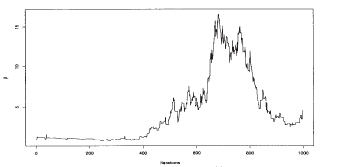

### Fig.2 - First 1,000 iterations
This plot shows the evolution of a Markov chain $\theta^{(t)}$ for the initial 1,000 iterations where $(\theta^{(0)},\omega^{(0)}) = (1,2)$. The chain exhibits significant fluctuations with a large peak around iteration 600, suggesting that 1,000 iterations may not be sufficient for convergence.

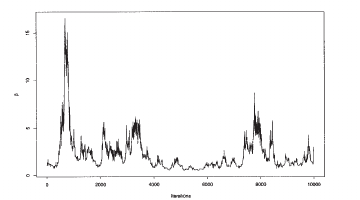

### Fig.3 - First 10,000 iterations
This plot extends the analysis to 10,000 iterations. We observe multiple peaks and valleys, indicating that the chain still hasn't fully stabilized. It appears to be exploring different regions of the parameter space but hasn't settled into a stationary distribution.

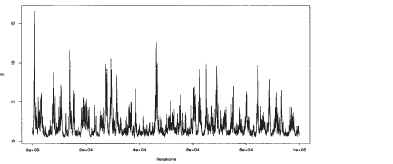

### Fig.4 - Full 100,000 iterations
This shows the complete run of 100,000 iterations. The pattern displays more consistent behavior over the longer run, though still with significant variability. This suggests that a very large number of iterations may be required for this particular model to achieve stationarity.

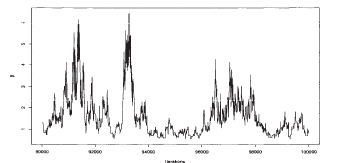

### Fig.5 - Last 10,000 of 100,000 iterations
This zoom-in on the final 10,000 iterations (out of 100,000) shows the behavior of the chain after it has had substantial time to converge. We can see more stable patterns, though still with some large excursions.

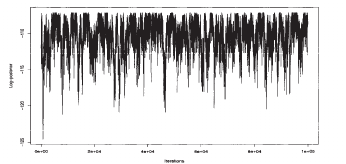

### Fig.6 - Function values over iterations

This shows the evolution of a function $\pi(\theta^{(t)},\epsilon^{(t)})$ over 100,000 iterations, displaying rapid mixing and more stationary behavior than the parameter itself.

## Mathematical Framework for Stationarity Tests

### Nonparametric Tests of Stationarity
For formal assessment, the Kolmogorov-Smirnov or Kuiper tests can be applied to evaluate stationarity of a single output. When a chain is stationary, the distributions $\theta^{(t_1)}$ and $\theta^{(t_2)}$ should be the same for arbitrary times $t_1$ and $t_2$.

Given an MCMC sample $\theta^{(1)},\ldots,\theta^{(T)}$, we can compare the distributions of the first and second halves:
$(\theta^{(1)},\ldots,\theta^{(T/2)})$ and $(\theta^{(T/2+1)},\ldots,\theta^{(T)})$

The Kolmogorov-Smirnov statistic is defined as:

$$K = \frac{1}{M} \sup \left| \sum_{i=1}^M I_{[0,a]}(\theta_i^{(T_1)}) - \sum_{i=1}^M I_{[0,a]}(\theta_i^{(T_2)}) \right|$$

Where $I_{[0,a]}$ is the indicator function for the interval $[0,a]$.

This statistic must be adjusted to account for autocorrelation between the $\theta^{(t)}$ samples.

## Key Insights
1. Longer run lengths are generally required for MCMC convergence than might be initially expected
2. Visual inspection of chain trajectories provides valuable initial diagnostics
3. The marginal posterior distribution stabilizes more quickly for some parameters than others
4. Formal statistical tests provide objective measures of convergence beyond visual inspection

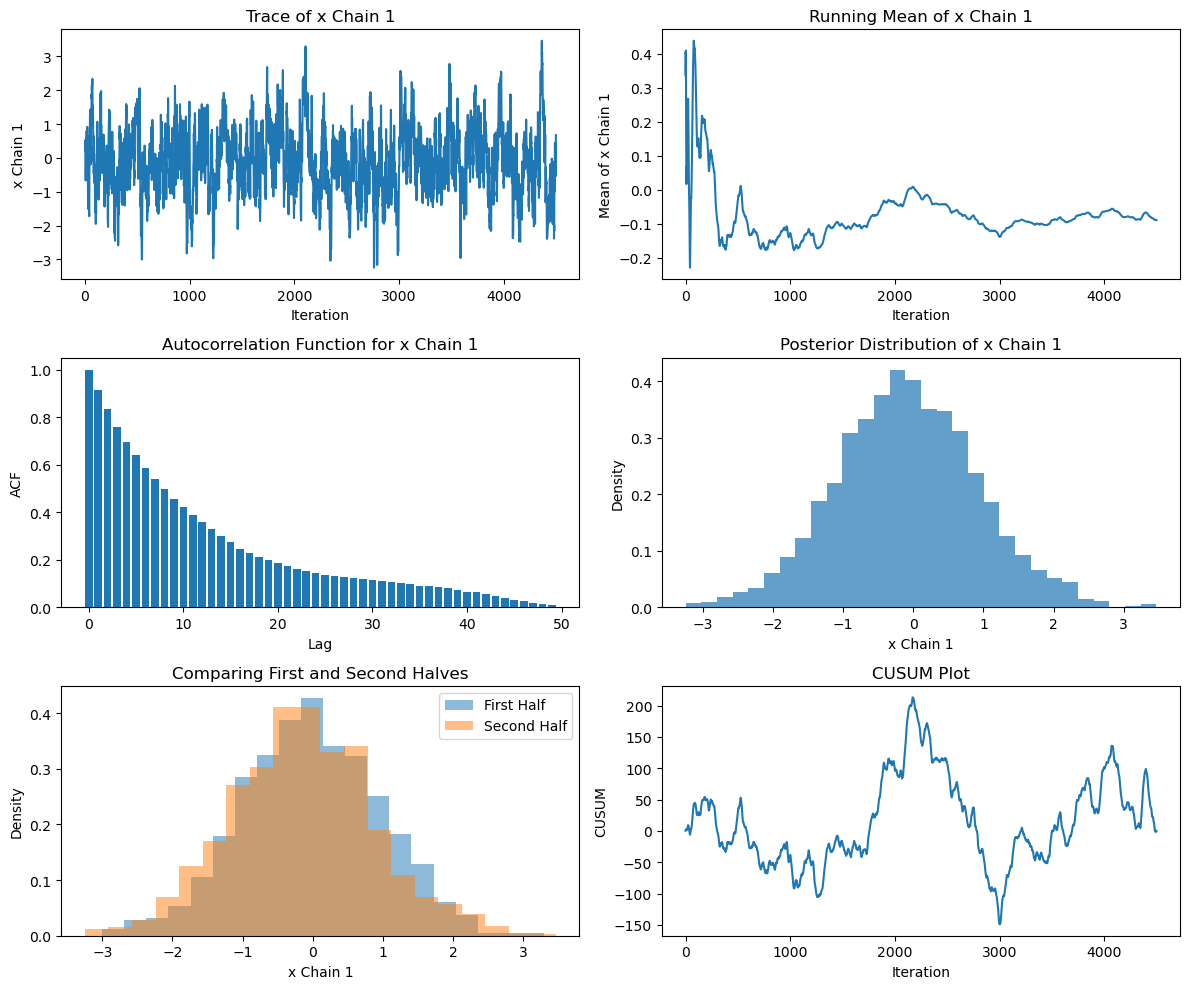

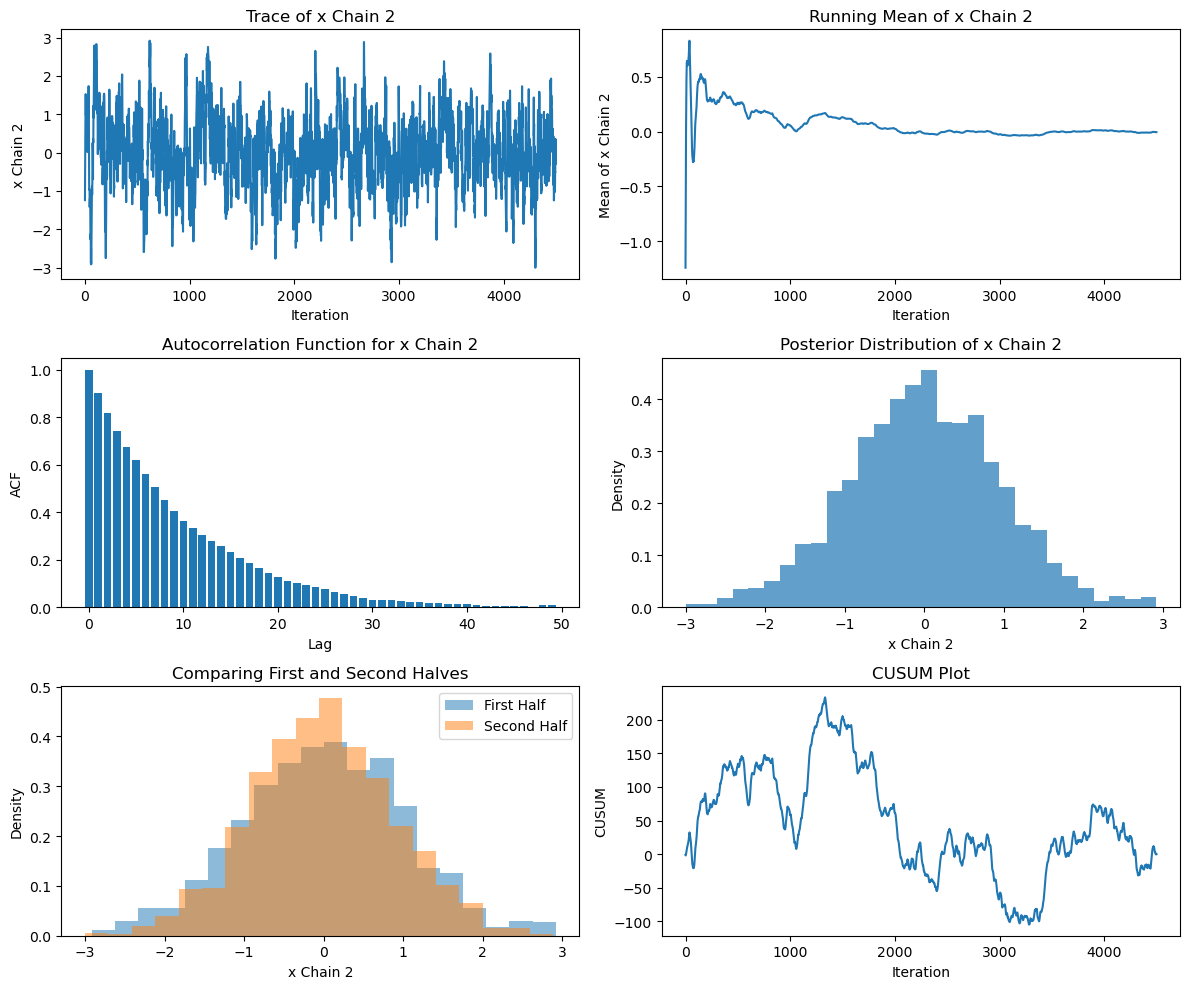

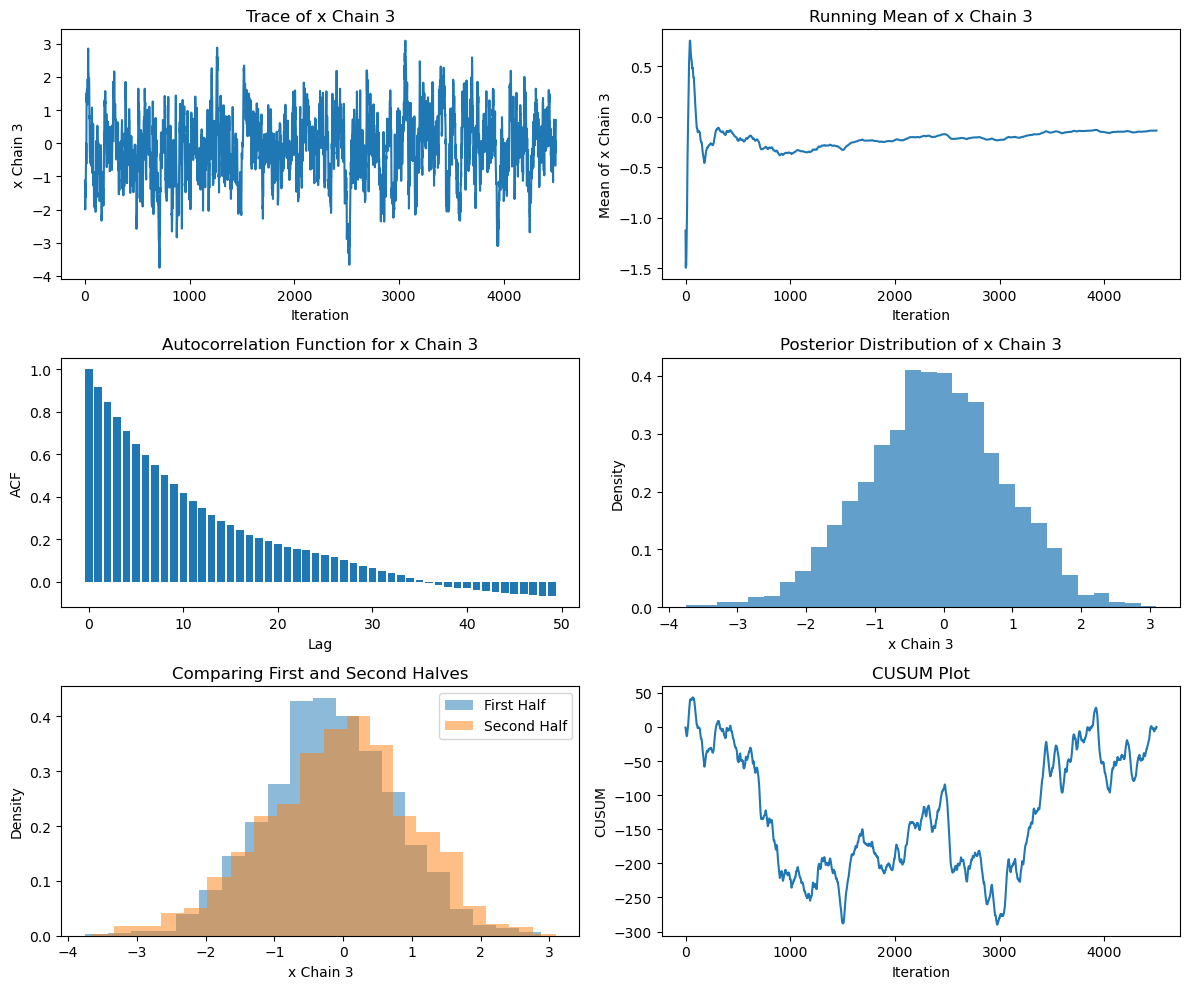

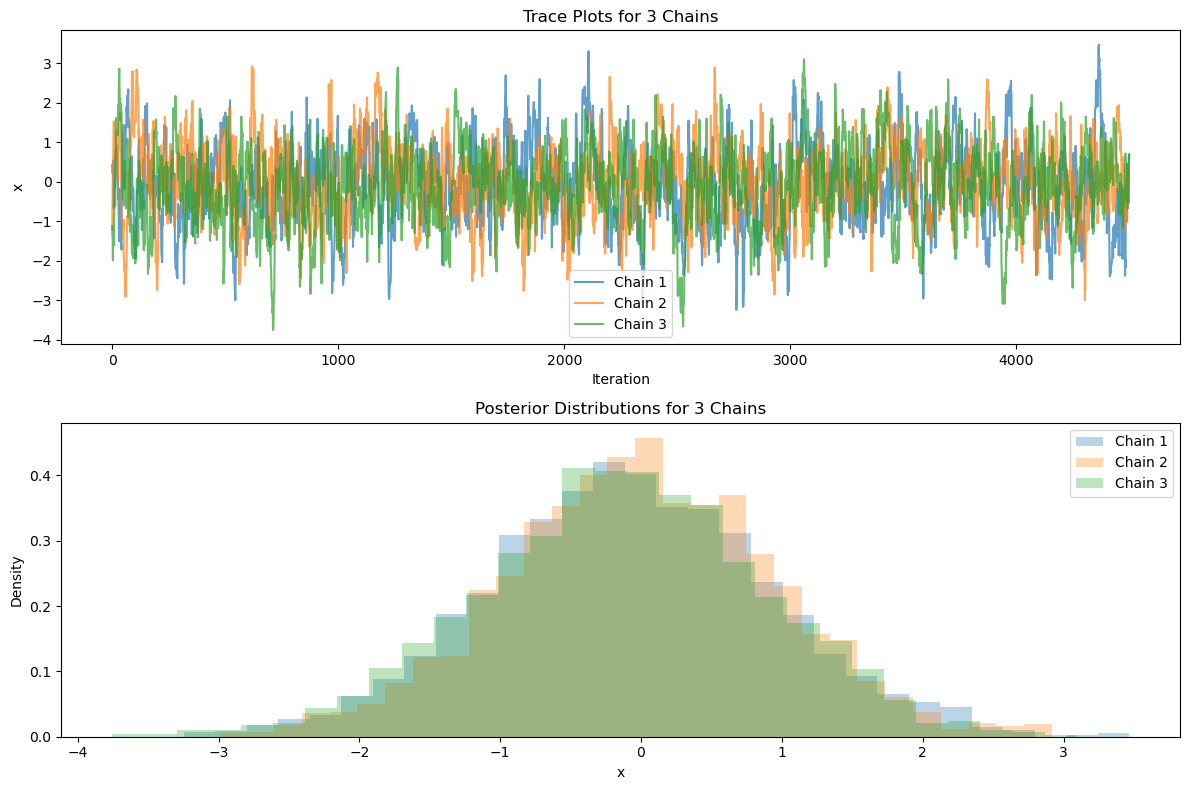

MCMC CONVERGENCE DIAGNOSTIC REPORT

OVERALL CONVERGENCE ASSESSMENT:
----------------------------------------
✓ Chains appear to have converged (R̂ < 1.1)
Gelman-Rubin statistic (R̂): 1.0021

POSTERIOR SUMMARY (COMBINED CHAINS):
----------------------------------------
Mean: -0.0769
Median: -0.0814
Standard Deviation: 0.9926
Quantiles:
  2.5%: -2.0612
  25%: -0.7289
  75%: 0.5862
  97.5%: 1.8608

INDIVIDUAL CHAIN ASSESSMENTS:
----------------------------------------
Chain 1:
  Mean: -0.0889
  Effective sample size: 184.7 (4.10% efficiency)
  ✓ Chain appears stationary (KS test p-value > 0.05)
  KS test p-value: 0.9578
  ✓ Start and end regions are similar (Geweke test |z| < 1.96)
  Geweke test z-score: 0.5811

Chain 2:
  Mean: -0.0058
  Effective sample size: 209.6 (4.66% efficiency)
  ✓ Chain appears stationary (KS test p-value > 0.05)
  KS test p-value: 0.2391
  ✗ Start and end regions differ (Geweke test |z| >= 1.96)
  Geweke test z-score: 5.3716

Chain 3:
  Mean: -0.1360
  Effective

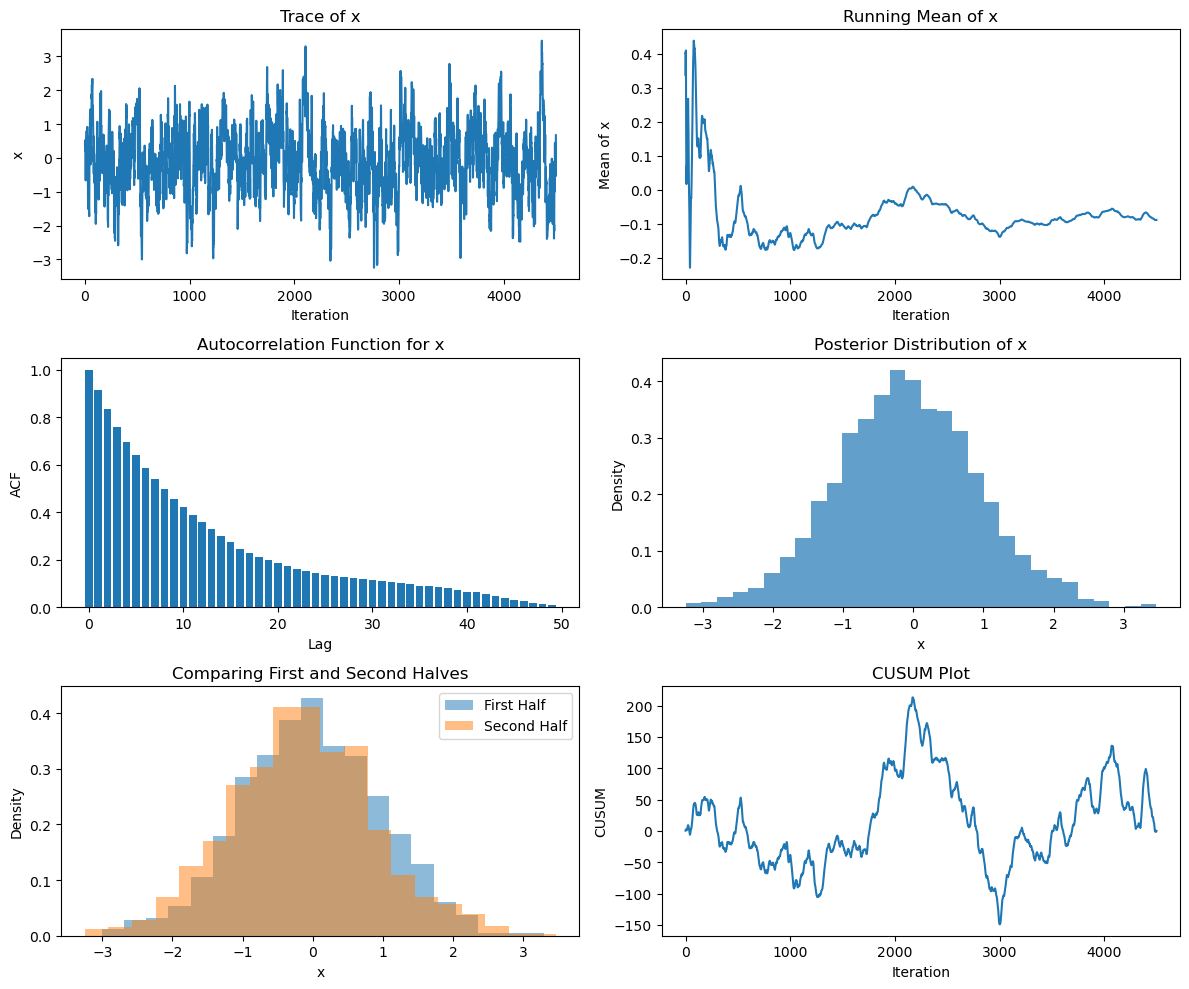

KS test p-value: 0.9578
Effective sample size: 184.7
Geweke test z-score: 0.5811


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def batch_ks_test(chain, batch_size=None):
    """
    Implements the Kolmogorov-Smirnov test for MCMC convergence with batch correction.
    
    Parameters:
    -----------
    chain : array-like
        The MCMC sample chain (1D)
    batch_size : int, optional
        Size of batches to use for reducing autocorrelation
        
    Returns:
    --------
    ks_statistic : float
        The KS test statistic
    p_value : float
        The p-value adjusted for autocorrelation
    """
    T = len(chain)
    
    # Split the chain into two halves
    first_half = chain[:T//2]
    second_half = chain[T//2:]
    
    if batch_size is None:
        # Estimate batch size using autocorrelation
        acf = np.array([np.corrcoef(chain[:-i], chain[i:])[0,1] for i in range(1, min(100, T//5))])
        batch_size = np.argmin(acf > 0.05) + 1
        batch_size = max(1, min(batch_size, T//20))  # Reasonable bounds
    
    # Create batched samples
    n_batches = min(T // (2 * batch_size), 30)  # Cap number of batches
    
    batched_first = np.array([
        np.mean(first_half[i*batch_size:(i+1)*batch_size]) 
        for i in range(n_batches)
    ])
    
    batched_second = np.array([
        np.mean(second_half[i*batch_size:(i+1)*batch_size]) 
        for i in range(n_batches)
    ])
    
    # Perform KS test on batched data
    ks_statistic, p_value = stats.ks_2samp(batched_first, batched_second)
    
    return ks_statistic, p_value


def determine_batch_size(chain, max_proportion=0.1, threshold=0.05):
    """
    Determine appropriate batch size G to correct for autocorrelation
    
    Parameters:
    -----------
    chain : array-like
        The MCMC chain
    max_proportion : float
        Maximum proportion of chain length to use as batch size
    threshold : float
        Autocorrelation threshold below which we consider observations independent
        
    Returns:
    --------
    batch_size : int
        Recommended batch size
    """
    T = len(chain)
    max_lag = min(int(T * max_proportion), 1000)
    
    # Calculate autocorrelation
    acf = np.array([np.corrcoef(chain[:-i], chain[i:])[0,1] for i in range(1, max_lag)])
    
    # Find lag where autocorrelation drops below threshold
    below_threshold = np.where(acf < threshold)[0]
    
    if len(below_threshold) > 0:
        # First lag where autocorrelation drops below threshold
        batch_size = below_threshold[0] + 1
    else:
        # If autocorrelation remains high, use a reasonable default
        batch_size = int(T * 0.05)
        
    return batch_size


def gelman_rubin(chains):
    """
    Calculate the Gelman-Rubin potential scale reduction factor (R̂)
    
    Parameters:
    -----------
    chains : list of arrays
        List containing M chains, each of length N
        
    Returns:
    --------
    r_hat : float
        Potential scale reduction factor. Values close to 1 indicate convergence.
    """
    M = len(chains)  # Number of chains
    N = len(chains[0])  # Length of each chain
    
    # Calculate within-chain and between-chain variances
    chain_means = np.array([np.mean(chain) for chain in chains])
    overall_mean = np.mean(chain_means)
    
    # Between-chain variance
    B = N * np.sum((chain_means - overall_mean)**2) / (M - 1)
    
    # Within-chain variance
    W = np.mean([np.var(chain, ddof=1) for chain in chains])
    
    # Estimated variance of the parameter
    var_plus = ((N - 1) / N) * W + B / N
    
    # Potential scale reduction factor
    r_hat = np.sqrt(var_plus / W)
    
    return r_hat


def geweke_test(chain, first_perc=0.1, last_perc=0.5):
    """
    Implements the Geweke test for MCMC convergence
    
    Parameters:
    -----------
    chain : array-like
        The MCMC sample chain
    first_perc : float
        Percentage of the beginning of the chain to use
    last_perc : float
        Percentage of the end of the chain to use
        
    Returns:
    --------
    z_score : float
        Z-score for the difference between means
    p_value : float
        P-value for the test
    """
    T = len(chain)
    
    first_part = chain[:int(T * first_perc)]
    last_part = chain[int(T * (1 - last_perc)):]
    
    mean_first = np.mean(first_part)
    mean_last = np.mean(last_part)
    
    var_first = np.var(first_part) / len(first_part)
    var_last = np.var(last_part) / len(last_part)
    
    z_score = (mean_first - mean_last) / np.sqrt(var_first + var_last)
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
    
    return z_score, p_value


def calculate_ess(chain):
    """
    Calculate the Effective Sample Size (ESS) of an MCMC chain
    
    Parameters:
    -----------
    chain : array-like
        The MCMC sample chain
        
    Returns:
    --------
    ess : float
        Effective sample size
    """
    T = len(chain)
    
    # Calculate autocorrelation up to a reasonable lag
    max_lag = min(T // 5, 100)
    acf = np.array([1] + [np.corrcoef(chain[:-i], chain[i:])[0,1] for i in range(1, max_lag)])
    
    # Truncate at first negative value or use all positive values
    pos_indices = np.where(acf > 0)[0]
    if len(pos_indices) < len(acf):
        last_pos = pos_indices[-1]
        acf = acf[:last_pos+1]
    
    # Calculate effective sample size
    ess = T / (1 + 2 * np.sum(acf[1:]))
    
    return ess


def assess_mcmc_convergence(chain, parameter_name="θ", burn_in=0.1):
    """
    Comprehensive MCMC convergence assessment with visual and statistical diagnostics
    
    Parameters:
    -----------
    chain : array-like
        The MCMC sample chain
    parameter_name : str
        Name of the parameter for plotting
    burn_in : float
        Proportion of the beginning of the chain to discard as burn-in
        
    Returns:
    --------
    results : dict
        Dictionary containing convergence metrics
    fig : matplotlib.figure.Figure
        Figure containing diagnostic plots
    """
    T = len(chain)
    burn_in_samples = int(T * burn_in)
    chain = chain[burn_in_samples:]  # Remove burn-in
    T = len(chain)
    
    results = {}
    
    # 1. Trace plot
    fig = plt.figure(figsize=(12, 10))
    
    plt.subplot(3, 2, 1)
    plt.plot(range(T), chain)
    plt.title(f"Trace of {parameter_name}")
    plt.xlabel("Iteration")
    plt.ylabel(parameter_name)
    
    # 2. Running mean plot
    plt.subplot(3, 2, 2)
    running_mean = np.cumsum(chain) / np.arange(1, T+1)
    plt.plot(range(T), running_mean)
    plt.title(f"Running Mean of {parameter_name}")
    plt.xlabel("Iteration")
    plt.ylabel(f"Mean of {parameter_name}")
    
    # 3. Autocorrelation function
    plt.subplot(3, 2, 3)
    max_lag = min(50, T//5)
    acf = np.array([1] + [np.corrcoef(chain[:-i], chain[i:])[0,1] for i in range(1, max_lag)])
    plt.bar(range(len(acf)), acf)
    plt.title(f"Autocorrelation Function for {parameter_name}")
    plt.xlabel("Lag")
    plt.ylabel("ACF")
    
    # 4. Histogram of values
    plt.subplot(3, 2, 4)
    plt.hist(chain, bins=30, alpha=0.7, density=True)
    plt.title(f"Posterior Distribution of {parameter_name}")
    plt.xlabel(parameter_name)
    plt.ylabel("Density")
    
    # 5. Split chain distributions (first half vs second half)
    plt.subplot(3, 2, 5)
    first_half = chain[:T//2]
    second_half = chain[T//2:]
    
    plt.hist(first_half, bins=20, alpha=0.5, density=True, label="First Half")
    plt.hist(second_half, bins=20, alpha=0.5, density=True, label="Second Half")
    plt.title("Comparing First and Second Halves")
    plt.xlabel(parameter_name)
    plt.ylabel("Density")
    plt.legend()
    
    # 6. Cusum path
    plt.subplot(3, 2, 6)
    centered_chain = chain - np.mean(chain)
    cusum = np.cumsum(centered_chain)
    plt.plot(range(T), cusum)
    plt.title("CUSUM Plot")
    plt.xlabel("Iteration")
    plt.ylabel("CUSUM")
    
    plt.tight_layout()
    
    # Statistical tests
    # Kolmogorov-Smirnov test with batch correction
    batch_size = determine_batch_size(chain)
    ks_stat, p_value = batch_ks_test(chain, batch_size=batch_size)
    results["recommended_batch_size"] = batch_size
    results["ks_statistic"] = ks_stat
    results["ks_p_value"] = p_value
    results["stationary_at_0.05"] = p_value > 0.05
    
    # Effective Sample Size
    ess = calculate_ess(chain)
    results["effective_sample_size"] = ess
    results["efficiency"] = ess / T
    
    # Geweke test
    geweke_z, geweke_p = geweke_test(chain)
    results["geweke_z"] = geweke_z
    results["geweke_p_value"] = geweke_p
    
    # Basic statistics
    results["mean"] = np.mean(chain)
    results["median"] = np.median(chain)
    results["std_dev"] = np.std(chain)
    results["quantiles"] = {
        "2.5%": np.percentile(chain, 2.5),
        "25%": np.percentile(chain, 25),
        "75%": np.percentile(chain, 75),
        "97.5%": np.percentile(chain, 97.5)
    }
    
    return results, fig


def run_multiple_chains(initial_values, n_iterations, target_function, proposal_sd=0.1):
    """
    Run multiple MCMC chains for convergence diagnostics
    
    Parameters:
    -----------
    initial_values : list
        Starting values for each chain
    n_iterations : int
        Number of iterations to run
    target_function : callable
        Function proportional to log probability of target distribution
    proposal_sd : float
        Standard deviation for Gaussian proposal
        
    Returns:
    --------
    chains : list of arrays
        List of MCMC chains
    """
    n_chains = len(initial_values)
    chains = []
    
    for initial_value in initial_values:
        chain = np.zeros(n_iterations)
        chain[0] = initial_value
        
        # Simple Metropolis algorithm
        for i in range(1, n_iterations):
            current = chain[i-1]
            proposed = current + np.random.normal(0, proposal_sd)
            
            # Calculate acceptance probability
            current_log_prob = target_function(current)
            proposed_log_prob = target_function(proposed)
            
            log_accept_ratio = proposed_log_prob - current_log_prob
            
            # Accept or reject
            if np.log(np.random.random()) < log_accept_ratio:
                chain[i] = proposed
            else:
                chain[i] = current
                
        chains.append(chain)
        
    return chains


def analyze_all_chains(chains, parameter_name="θ", burn_in=0.1):
    """
    Analyze multiple chains and assess convergence
    
    Parameters:
    -----------
    chains : list of arrays
        List of MCMC chains
    parameter_name : str
        Name of the parameter
    burn_in : float
        Proportion of each chain to discard as burn-in
        
    Returns:
    --------
    results : dict
        Dictionary of convergence diagnostics
    """
    n_chains = len(chains)
    
    # Apply burn-in to all chains
    burn_in_samples = int(len(chains[0]) * burn_in)
    burned_chains = [chain[burn_in_samples:] for chain in chains]
    
    # Calculate Gelman-Rubin statistic
    r_hat = gelman_rubin(burned_chains)
    
    # Combine chains for overall summary
    combined_chain = np.concatenate(burned_chains)
    
    # Assess individual chains
    individual_results = []
    for i, chain in enumerate(burned_chains):
        result, _ = assess_mcmc_convergence(chain, parameter_name=f"{parameter_name} Chain {i+1}", burn_in=0)
        individual_results.append(result)
    
    # Create summary plot
    fig = plt.figure(figsize=(12, 8))
    
    # Plot all chains
    plt.subplot(2, 1, 1)
    for i, chain in enumerate(burned_chains):
        plt.plot(range(len(chain)), chain, alpha=0.7, label=f"Chain {i+1}")
    plt.title(f"Trace Plots for {n_chains} Chains")
    plt.xlabel("Iteration")
    plt.ylabel(parameter_name)
    plt.legend()
    
    # Plot density for all chains
    plt.subplot(2, 1, 2)
    for i, chain in enumerate(burned_chains):
        plt.hist(chain, bins=30, alpha=0.3, density=True, label=f"Chain {i+1}")
    plt.title(f"Posterior Distributions for {n_chains} Chains")
    plt.xlabel(parameter_name)
    plt.ylabel("Density")
    plt.legend()
    
    plt.tight_layout()
    
    # Create comprehensive report
    results = {
        "n_chains": n_chains,
        "r_hat": r_hat,
        "convergence_achieved": r_hat < 1.1,
        "individual_chain_results": individual_results,
        "combined_chain_mean": np.mean(combined_chain),
        "combined_chain_median": np.median(combined_chain),
        "combined_chain_std": np.std(combined_chain),
        "combined_chain_quantiles": {
            "2.5%": np.percentile(combined_chain, 2.5),
            "25%": np.percentile(combined_chain, 25),
            "75%": np.percentile(combined_chain, 75),
            "97.5%": np.percentile(combined_chain, 97.5)
        }
    }
    
    return results, fig


def create_diagnostic_report(results, chains=None):
    """
    Create a comprehensive diagnostic report for MCMC convergence
    
    Parameters:
    -----------
    results : dict
        Results from analyze_all_chains function
    chains : list of arrays, optional
        Raw MCMC chains for additional analysis
        
    Returns:
    --------
    report_text : str
        Text report of convergence diagnostics
    """
    report = []
    report.append("=" * 60)
    report.append("MCMC CONVERGENCE DIAGNOSTIC REPORT")
    report.append("=" * 60)
    report.append("")
    
    # Overall convergence assessment
    report.append("OVERALL CONVERGENCE ASSESSMENT:")
    report.append("-" * 40)
    
    if results["convergence_achieved"]:
        report.append("✓ Chains appear to have converged (R̂ < 1.1)")
    else:
        report.append("✗ Chains may not have converged (R̂ >= 1.1)")
    
    report.append(f"Gelman-Rubin statistic (R̂): {results['r_hat']:.4f}")
    report.append("")
    
    # Combined chain summary
    report.append("POSTERIOR SUMMARY (COMBINED CHAINS):")
    report.append("-" * 40)
    report.append(f"Mean: {results['combined_chain_mean']:.4f}")
    report.append(f"Median: {results['combined_chain_median']:.4f}")
    report.append(f"Standard Deviation: {results['combined_chain_std']:.4f}")
    report.append("Quantiles:")
    for q, val in results['combined_chain_quantiles'].items():
        report.append(f"  {q}: {val:.4f}")
    report.append("")
    
    # Individual chain assessments
    report.append("INDIVIDUAL CHAIN ASSESSMENTS:")
    report.append("-" * 40)
    
    for i, chain_result in enumerate(results["individual_chain_results"]):
        report.append(f"Chain {i+1}:")
        report.append(f"  Mean: {chain_result['mean']:.4f}")
        report.append(f"  Effective sample size: {chain_result['effective_sample_size']:.1f} " +
                     f"({chain_result['efficiency']:.2%} efficiency)")
        
        if chain_result["stationary_at_0.05"]:
            report.append("  ✓ Chain appears stationary (KS test p-value > 0.05)")
        else:
            report.append("  ✗ Chain may not be stationary (KS test p-value <= 0.05)")
        
        report.append(f"  KS test p-value: {chain_result['ks_p_value']:.4f}")
        
        if abs(chain_result["geweke_z"]) < 1.96:
            report.append("  ✓ Start and end regions are similar (Geweke test |z| < 1.96)")
        else:
            report.append("  ✗ Start and end regions differ (Geweke test |z| >= 1.96)")
        
        report.append(f"  Geweke test z-score: {chain_result['geweke_z']:.4f}")
        report.append("")
    
    # Recommendations
    report.append("RECOMMENDATIONS:")
    report.append("-" * 40)
    
    if not results["convergence_achieved"]:
        report.append("• Consider running chains longer")
        report.append("• Try different initial values that are more dispersed")
        report.append("• Check if the target distribution has multiple modes")
    
    min_ess = min([r["effective_sample_size"] for r in results["individual_chain_results"]])
    if min_ess < 100:
        report.append("• Effective sample size is small - consider thinning or longer runs")
    
    report.append("• Discard first 10-25% of each chain as burn-in")
    
    low_efficiency = any([r["efficiency"] < 0.1 for r in results["individual_chain_results"]])
    if low_efficiency:
        report.append("• Consider improving proposal distribution to increase efficiency")
    
    report.append("")
    report.append("=" * 60)
    
    return "\n".join(report)


def plot_joint_evolution(chains, parameter_names, burn_in=0.1):
    """
    Plot the joint evolution of multiple parameters from MCMC chains
    
    Parameters:
    -----------
    chains : dict of arrays
        Dictionary with parameter names as keys and chains as values
    parameter_names : list of str
        Names of parameters to plot
    burn_in : float
        Proportion of each chain to discard as burn-in
    """
    n_params = len(parameter_names)
    if n_params < 2:
        raise ValueError("Need at least 2 parameters to plot joint evolution")
    
    # Apply burn-in
    chain_length = len(chains[parameter_names[0]])
    burn_in_samples = int(chain_length * burn_in)
    burned_chains = {name: chains[name][burn_in_samples:] for name in parameter_names}
    
    # Create pairplot
    fig, axes = plt.subplots(n_params, n_params, figsize=(12, 12))
    
    for i, param_i in enumerate(parameter_names):
        for j, param_j in enumerate(parameter_names):
            ax = axes[i, j]
            
            if i == j:  # Diagonal: histogram
                ax.hist(burned_chains[param_i], bins=30)
                ax.set_title(param_i)
            elif j < i:  # Lower triangle: scatter plot with time gradient
                chain_i = burned_chains[param_i]
                chain_j = burned_chains[param_j]
                
                # Color points by iteration to show evolution
                points = ax.scatter(chain_j, chain_i, c=range(len(chain_i)), 
                                  cmap='viridis', alpha=0.5, s=2)
                ax.set_xlabel(param_j)
                ax.set_ylabel(param_i)
            else:  # Upper triangle: 2D density
                ax.hexbin(burned_chains[param_j], burned_chains[param_i], 
                         gridsize=20, cmap='Blues')
                ax.set_xlabel(param_j)
                ax.set_ylabel(param_i)
    
    plt.tight_layout()
    return fig


# Example usage
if __name__ == "__main__":
    # Define a target distribution (standard normal for simplicity)
    def target_log_prob(x):
        return -0.5 * x**2
    
    # Run multiple chains
    initial_values = [-3, 0, 3]  # Dispersed starting points
    chains = run_multiple_chains(initial_values, n_iterations=5000, 
                                target_function=target_log_prob, proposal_sd=0.5)
    
    # Analyze convergence
    results, fig = analyze_all_chains(chains, parameter_name="x")
    plt.show()
    
    # Print diagnostic report
    report = create_diagnostic_report(results)
    print(report)
    
    # For a single chain analysis
    single_results, single_fig = assess_mcmc_convergence(chains[0], parameter_name="x")
    plt.show()
    
    print(f"KS test p-value: {single_results['ks_p_value']:.4f}")
    print(f"Effective sample size: {single_results['effective_sample_size']:.1f}")
    print(f"Geweke test z-score: {single_results['geweke_z']:.4f}")

# Analysis of Statistical Distributions and Nuclear Pump Failures

## Comparison of the Distribution of the Sequence

The following figure compares the distribution of the sequence of $\hat{p}^{(k)}$, $\hat{q}^{(k)}$ over the first 5,000 iterations (top) and the last 5,000 iterations (bottom), along 100,000 iterations.

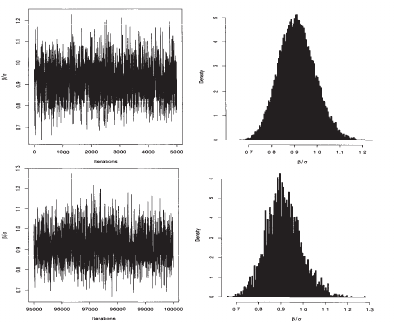


**Fig. 12.7.** Comparison of the distribution of the sequence of $\hat{p}^{(k)}$, $\hat{q}^{(k)}$ over the first 5,000 iterations (top) and the last 5,000 iterations (bottom), along 100,000 iterations.

The equation for $R(k)$ is given by:

$$
R(k) = 1 - \sum_{k=1}^{\infty} (-1)^k e^{-2k^2 x^2}
$$

which can be easily approximated by a finite sum (see Problem 12.2). The corresponding $p$-value can therefore be computed for each $T$ until it gets above a given level. An approximation of the 95% quantile, $q_0 = 1.36$ (for $M > 100$), simplifies this stage.) Of course, to produce a valid inference, we must take into account the sequential nature of the test and the fact that $K$ is computed as the infimum over all components of $\hat{p}^{(k)}$.

An exact derivation of the level of the derived test is quite difficult given the correlation between the $\hat{p}^{(k)}$'s and the influence of the subsampling mechanism. Another use of (12.2), which is more graphical, is to represent the sample of $V_M K_T$'s against $T$ and to check visually for a stable distribution around small values. (See also Brooks et al., 2003a, for another approach using the Kolmogorov–Smirnov test.)

##  Plot of 100 Kolmogorov–Smirnov Statistics

The following figure shows a plot of 100 Kolmogorov–Smirnov statistics for $T = 1000$ and $T = 10,000$ iterations. The dotted line corresponds to the 95% level.

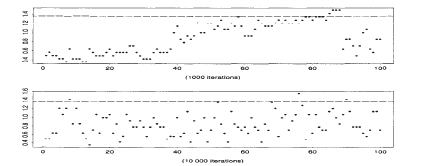

**Fig. 12.8.** Plot of 100 Kolmogorov–Smirnov statistics for $T = 1000$ and $T = 10,000$ iterations. The dotted line corresponds to the 95% level.

Obviously, an assessment of stationarity based on a single chain is open to criticism. In cases of strong attraction from a local mode, the chain will most likely behave as if it was simulated from the restriction of \(f\) to the neighborhood of this mode and thus lead to a convergence diagnosis (this is the “you’ve only seen where you’ve been” defect mentioned in Section 12.1.2). However, in more intermediate cases, where the chain $\hat{p}^{(k)}$ stays for a while in the neighborhood of a mode before visiting another modal region, the subsamples $\hat{p}^{(k)}$ and $\hat{q}^{(k)}$ should exhibit different features until the chain explores every modal region.

##  Nuclear Pump Failures

O’Muircheartaigh (1987), described in Example .17, we consider the subchain $\hat{p}^{(k)}$ produced by the algorithm. Fig.8 gives the values of the Kolmogorov–Smirnov statistics $K$ for $T = 1000$ and $T = 10,000$ iterations, with $M = 100$ and 100 statistics for $T$. Although both cases lead to similar proportions of about 95% values under the level 1.36, the first case clearly lacks the required homogeneity, since the statistic is almost monotone in $t$. This behavior may correspond to the local exploration of a modal region for $t \leq 400$ and to the move to another region of importance for $400 \leq t \leq 500$.

##  Renewal Methods

Chapter 6 has presented the basis of renewal theory in Section 6.3.2 through the notion of small set (Definition 6.19). This theory is then used in Section 6.4 for a direct derivation of many limit theorems (Theorems 6.63 and 6.64). It is also possible to take advantage of this theory for the purpose(s) of convergence control, either through small sets as in Robert (1995a) or through the

## Analysis and Implementation of Statistical Distributions and KS Statistics

##  Comparison of the Distribution of the Sequence

The following figure compares the distribution of the sequence of $\hat{p}^{(k)}$, $\hat{q}^{(k)}$ over the first 5,000 iterations (top) and the last 5,000 iterations (bottom), along 100,000 iterations.

The equation for $R(k)$ is given by:

$$
R(k) = 1 - \sum_{k=1}^{\infty} (-1)^k e^{-2k^2 x^2}
$$

which can be easily approximated by a finite sum (see Problem 12.2). The corresponding $p$-value can therefore be computed for each $T$ until it gets above a given level. An approximation of the 95% quantile, $q_0 = 1.36$ (for $M > 100$), simplifies this stage.) Of course, to produce a valid inference, we must take into account the sequential nature of the test and the fact that $K$ is computed as the infimum over all components of $\hat{p}^{(k)}$.

An exact derivation of the level of the derived test is quite difficult given the correlation between the \(\hat{p}^{(k)}\)'s and the influence of the subsampling mechanism. Another use of (12.2), which is more graphical, is to represent the sample of \(V_M K_T\)'s against \(T\) and to check visually for a stable distribution around small values. (See also Brooks et al., 2003a, for another approach using the Kolmogorov–Smirnov test.)

## Plot of 100 Kolmogorov–Smirnov Statistics

The following figure shows a plot of 100 Kolmogorov–Smirnov statistics for $T = 1000$ and $T = 10,000$ iterations. The dotted line corresponds to the 95% level.

Obviously, an assessment of stationarity based on a single chain is open to criticism. In cases of strong attraction from a local mode, the chain will most likely behave as if it was simulated from the restriction of $f$ to the neighborhood of this mode and thus lead to a convergence diagnosis (this is the “you’ve only seen where you’ve been” defect mentioned in Section 12.1.2). However, in more intermediate cases, where the chain $\hat{p}^{(k)}$ stays for a while in the neighborhood of a mode before visiting another modal region, the subsamples $\hat{p}^{(k)}$ and $\hat{q}^{(k)}$ should exhibit different features until the chain explores every modal region.

## Nuclear Pump Failures

O’Muircheartaigh (1987), described in Example 10.17, we consider the subchain $\hat{p}^{(k)}$ produced by the algorithm. Fig.8 gives the values of the Kolmogorov–Smirnov statistics $K$ for $T = 1000$ and $T = 10,000$ iterations, with \(M = 100\) and 100 statistics for $T$. Although both cases lead to similar proportions of about 95% values under the level 1.36, the first case clearly lacks the required homogeneity, since the statistic is almost monotone in $t$. This behavior may correspond to the local exploration of a modal region for $t \leq 400$ and to the move to another region of importance for $400 \leq t \leq 500$.

##  Renewal Methods

Chapter 6 has presented the basis of renewal theory in Section 6.3.2 through the notion of small set (Definition 6.19). This theory is then used in Section 6.4 for a direct derivation of many limit theorems (Theorems 6.63 and 6.64). It is also possible to take advantage of this theory for the purpose(s) of convergence control, either through small sets as in Robert (1995a).

## Implementation: Simulate, Plot, and Analyze

Below is the complete implementation in a single code block. It simulates the sequences $\hat{p}^{(k)}$ and $\hat{q}^{(k)}$, plots their distributions (Fig. 12.7), computes and plots the Kolmogorov-Smirnov (KS) statistics (Fig. 12.8), and analyzes the proportions of KS statistics below the 95% threshold.



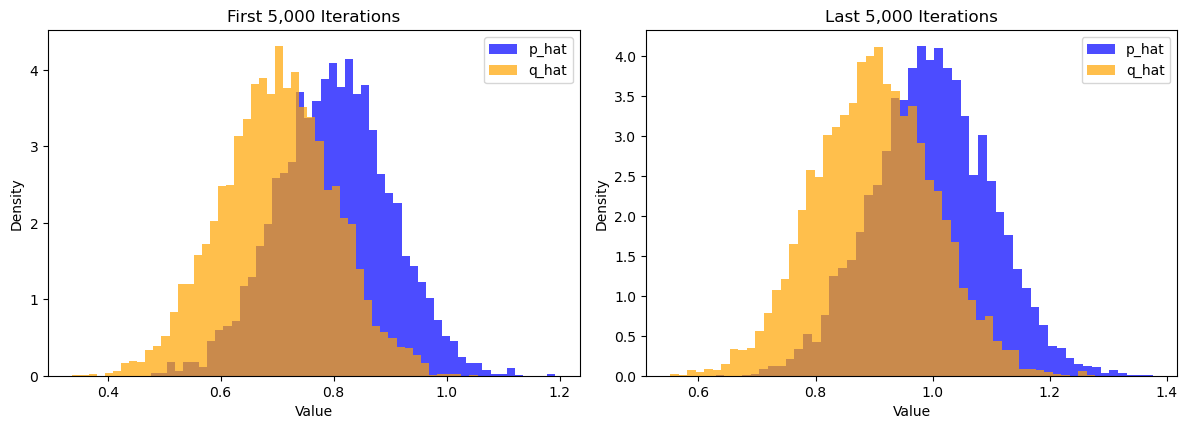

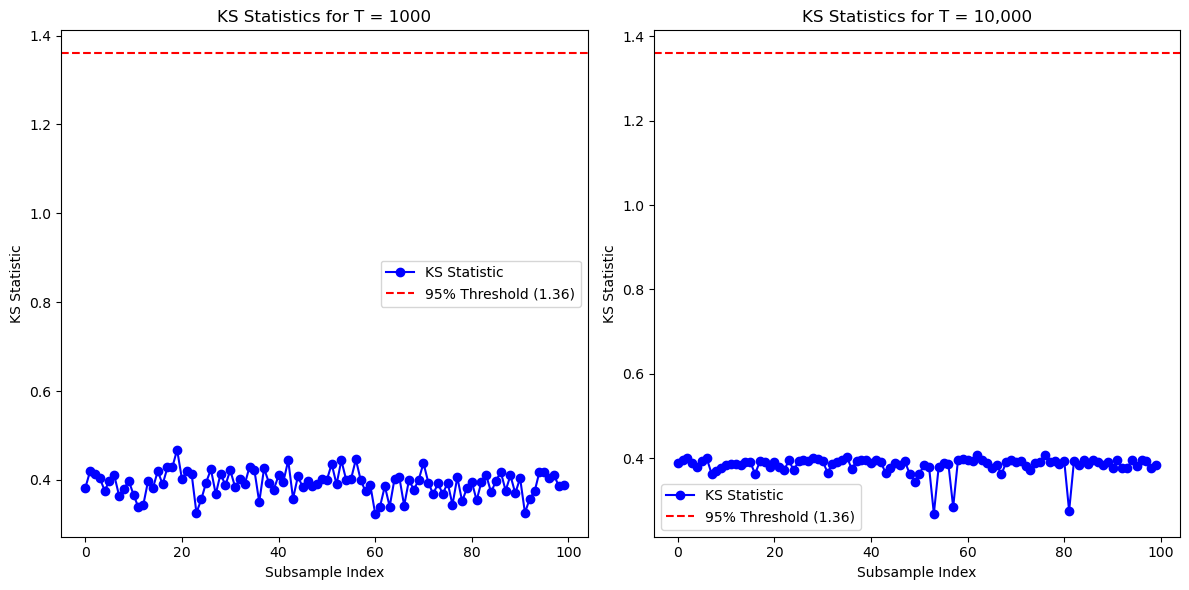

Proportion of KS statistics below threshold for T = 1000: 1.000
Proportion of KS statistics below threshold for T = 10000: 1.000


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Set random seed for reproducibility
np.random.seed(42)

# Simulate a sequence of p_hat and q_hat over 100,000 iterations
# For simplicity, we assume p_hat and q_hat are drawn from normal distributions
# with slight shifts to mimic non-stationarity
iterations = 100000
p_hat = np.zeros(iterations)
q_hat = np.zeros(iterations)

# Simulate non-stationary behavior: early iterations have a different mean
p_hat[:50000] = np.random.normal(loc=0.8, scale=0.1, size=50000)  # Early iterations
p_hat[50000:] = np.random.normal(loc=1.0, scale=0.1, size=50000)  # Later iterations
q_hat[:50000] = np.random.normal(loc=0.7, scale=0.1, size=50000)  # Early iterations
q_hat[50000:] = np.random.normal(loc=0.9, scale=0.1, size=50000)  # Later iterations

# Plot histograms for the first 5,000 and last 5,000 iterations (Fig. 12.7)
plt.figure(figsize=(12, 8))

# First 5,000 iterations
plt.subplot(2, 2, 1)
plt.hist(p_hat[:5000], bins=50, density=True, alpha=0.7, color='blue', label='p_hat')
plt.hist(q_hat[:5000], bins=50, density=True, alpha=0.7, color='orange', label='q_hat')
plt.title('First 5,000 Iterations')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Last 5,000 iterations
plt.subplot(2, 2, 2)
plt.hist(p_hat[-5000:], bins=50, density=True, alpha=0.7, color='blue', label='p_hat')
plt.hist(q_hat[-5000:], bins=50, density=True, alpha=0.7, color='orange', label='q_hat')
plt.title('Last 5,000 Iterations')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# Compute KS statistics for T = 1000 and T = 10,000
M = 100  # Number of subsamples
T_values = [1000, 10000]
ks_stats = {T: [] for T in T_values}

for T in T_values:
    for i in range(M):
        # Randomly sample two subsamples of size T/2 from p_hat and q_hat
        start_idx = np.random.randint(0, iterations - T)
        p_sample = p_hat[start_idx:start_idx + T//2]
        q_sample = q_hat[start_idx:start_idx + T//2]
        # Compute KS statistic
        ks_stat, _ = ks_2samp(p_sample, q_sample)
        ks_stats[T].append(ks_stat)

# Plot KS statistics (Fig. 12.8)
plt.figure(figsize=(12, 6))

# T = 1000
plt.subplot(1, 2, 1)
plt.plot(ks_stats[1000], marker='o', linestyle='-', color='blue', label='KS Statistic')
plt.axhline(y=1.36, color='red', linestyle='--', label='95% Threshold (1.36)')
plt.title('KS Statistics for T = 1000')
plt.xlabel('Subsample Index')
plt.ylabel('KS Statistic')
plt.legend()

# T = 10,000
plt.subplot(1, 2, 2)
plt.plot(ks_stats[10000], marker='o', linestyle='-', color='blue', label='KS Statistic')
plt.axhline(y=1.36, color='red', linestyle='--', label='95% Threshold (1.36)')
plt.title('KS Statistics for T = 10,000')
plt.xlabel('Subsample Index')
plt.ylabel('KS Statistic')
plt.legend()

plt.tight_layout()
plt.show()

# Compute proportion of KS statistics below the threshold
threshold = 1.36
for T in T_values:
    proportion = np.mean(np.array(ks_stats[T]) < threshold)
    print(f"Proportion of KS statistics below threshold for T = {T}: {proportion:.3f}")